## Setup

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

%cd /content
%ls

/content
data.csv               Dataset.zip  eric_cache/       labels.csv  sample_data/
Dataset_3_20_2024.csv  disk2/       labeled_data.csv  PPMI_test/  silvia_cache/


In [2]:
#!pip install pydicom

In [3]:
from PIL import Image
import dask.dataframe as dd
import os
import pydicom as dicom

from tensorflow import keras

from keras import Sequential
from keras.layers import Dense, Flatten, Conv3D, Conv2D, MaxPooling3D
from keras.utils import to_categorical

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys

## GPU Information

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)
  #For GPU tunning

Mon Apr 15 16:08:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')
  #FOR ram tunning

Your runtime has 31.6 gigabytes of available RAM

You are using a high-RAM runtime!


## Data processing

In [6]:
label_df = pd.read_csv('Dataset_3_20_2024.csv')
label_df['Subject'] = label_df['Subject'].astype(str)

# Create a dictionary where the key is the Subject and the value is the Group
group_mapping = label_df.set_index('Subject')['Group'].to_dict()

label_df

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I495208,92834,Prodromal,M,66,BL,MRI,MPRAGE GRAPPA2,Original,3/20/2015,DCM,NaN
1,I495209,92834,Prodromal,M,66,BL,MRI,Axial T2 TSE with Fat Sat,Original,3/20/2015,DCM,NaN
2,I440709,91837,Prodromal,M,74,BL,MRI,AX DUAL_TSE,Original,3/04/2014,DCM,NaN
3,I440711,91837,Prodromal,M,74,BL,MRI,Cor FLAIR TI_2800ms,Original,3/04/2014,DCM,NaN
4,I440710,91837,Prodromal,M,74,BL,MRI,SAG 3D T1,Original,3/04/2014,DCM,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
17437,I1473172,100001,PD,M,67,BL,MRI,SAG 3D MPRAGE,Original,10/07/2020,DCM,NaN
17438,I1473183,100001,PD,M,67,BL,MRI,AX T2 GRE MT,Original,10/07/2020,DCM,NaN
17439,I1658557,100001,PD,M,70,V06,MRI,AX T2 GRE MT,Original,11/29/2022,DCM,NaN
17440,I1658550,100001,PD,M,70,V06,MRI,AX T2 GRE MT,Original,11/29/2022,DCM,NaN


In [7]:
### get all image files and their attributes

DATA_DIR = '/content/disk2/PPMI'

file_data = []
for subj_id in os.listdir(DATA_DIR):
  for imaging_method in os.listdir(os.path.join(DATA_DIR, subj_id)):
    for date in os.listdir(os.path.join(DATA_DIR, subj_id, imaging_method)):
      for im_id in os.listdir(os.path.join(DATA_DIR, subj_id, imaging_method, date)):
        for image_name in os.listdir(os.path.join(DATA_DIR, subj_id, imaging_method, date, im_id)):
          absolute_path = os.path.join(DATA_DIR, subj_id, imaging_method, date, im_id, image_name)
          file_data.append({
              'Subject': subj_id,
              'imaging_method': imaging_method,
              'date_str': date,
              'Image Data ID': im_id,
              'file_name': image_name,
              'full_path': absolute_path
          })
fileinfo_df = pd.DataFrame(file_data)

# map the Group values to fileinfo_df
fileinfo_df['Group'] = fileinfo_df['Subject'].map(group_mapping)

# map Group to labels
fileinfo_df['label'] = fileinfo_df['Group'].map(lambda s: {'PD': 0, 'Prodromal': 1, 'Control': 2}.get(s, -1))

fileinfo_df

,Subject,imaging_method,date_str,Image Data ID,file_name,full_path,Group,label
0,3770,Axial_PD-T2_TSE,2012-02-08_10_16_11.0,I322876,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,/content/disk2/PPMI/3770/Axial_PD-T2_TSE/2012-...,PD,0
1,3770,Axial_PD-T2_TSE,2012-02-08_10_16_11.0,I322876,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,/content/disk2/PPMI/3770/Axial_PD-T2_TSE/2012-...,PD,0
2,3770,Axial_PD-T2_TSE,2012-02-08_10_16_11.0,I322876,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,/content/disk2/PPMI/3770/Axial_PD-T2_TSE/2012-...,PD,0
3,3770,Axial_PD-T2_TSE,2012-02-08_10_16_11.0,I322876,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,/content/disk2/PPMI/3770/Axial_PD-T2_TSE/2012-...,PD,0
4,3770,Axial_PD-T2_TSE,2012-02-08_10_16_11.0,I322876,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,/content/disk2/PPMI/3770/Axial_PD-T2_TSE/2012-...,PD,0
...,...,...,...,...,...,...,...,...
455021,4112,ax_flair,2013-03-10_09_37_52.0,I366364,PPMI_4112_MR_ax_flair_br_raw_20130410132828973...,/content/disk2/PPMI/4112/ax_flair/2013-03-10_0...,PD,0
455022,4112,ax_flair,2013-03-10_09_37_52.0,I366364,PPMI_4112_MR_ax_flair_br_raw_20130410132830986...,/content/disk2/PPMI/4112/ax_flair/2013-03-10_0...,PD,0
455023,4112,ax_flair,2013-03-10_09_37_52.0,I366364,PPMI_4112_MR_ax_flair_br_raw_20130410132844503...,/content/disk2/PPMI/4112/ax_flair/2013-03-10_0...,PD,0
455024,4112,ax_flair,2013-03-10_09_37_52.0,I366364,PPMI_4112_MR_ax_flair_br_raw_20130410132844862...,/content/disk2/PPMI/4112/ax_flair/2013-03-10_0...,PD,0


In [8]:
### statistics
for col in fileinfo_df:
  print(col, fileinfo_df[col].unique().size)

print()
print(fileinfo_df['label'].value_counts())

print()
print(fileinfo_df['imaging_method'].value_counts())

Subject 1463
imaging_method 214
date_str 1873
Image Data ID 2238
file_name 455026
full_path 455026
Group 4
label 4

 1    229880
 0    195993
 2     28224
-1       929
Name: label, dtype: int64

R_L_RESTING_STATE_FMRI_ep2d_fid_basic_bold    153600
rsfMRI_RL                                      38712
Resting_State_fMRI_R_L                         21120
MPRAGE_GRAPPA                                  20416
DTI_LR                                         13233
                                               ...  
DTI_RL_ColFA                                       1
Coronal                                            1
Transverse                                         1
DTI_LR_TENSOR_B0                                   1
DTI_RL_TRACEW                                      1
Name: imaging_method, Length: 214, dtype: int64


In [9]:
### image scan types
# Sagittal, Coronal, and Axial parts of the brain

scantype_indicators = {
    'sagittal': 'sag',
    'axial': 'ax',
    'coronal': 'cor',
}
scantype_counts = {scantype: 0 for scantype in scantype_indicators.keys()}
scantype_counts['unknown'] = 0

for desc in fileinfo_df['imaging_method']:
  types_assigned = 0

  # check established types
  for scantype, indicator in scantype_indicators.items():
    if indicator in desc.lower():
      scantype_counts[scantype] += 1
      types_assigned += 1

  # if nothing assigned, assign unknown
  if types_assigned == 0:
    scantype_counts['unknown'] += 1
  # if multiple assigned, print to debug
  if types_assigned >= 2:
    print(desc)

scantype_counts

{'sagittal': 33304, 'axial': 23764, 'coronal': 617, 'unknown': 397341}

In [10]:
### filter data down to MPRAGE_GRAPPA images
#data_df = fileinfo_df[fileinfo_df['imaging_method'].apply(lambda s: 'ax' in s.lower())]
data_df = fileinfo_df[fileinfo_df['imaging_method'] == 'MPRAGE_GRAPPA']
display(data_df)

### statistics
for col in data_df:
  print(col, data_df[col].unique().size)

print()
print(data_df['label'].value_counts())

print()
print(data_df['imaging_method'].value_counts())

,Subject,imaging_method,date_str,Image Data ID,file_name,full_path,Group,label
48,3770,MPRAGE_GRAPPA,2014-02-19_07_53_30.0,I420360,PPMI_3770_MR_MPRAGE_GRAPPA__br_raw_20140416154...,/content/disk2/PPMI/3770/MPRAGE_GRAPPA/2014-02...,PD,0
49,3770,MPRAGE_GRAPPA,2014-02-19_07_53_30.0,I420360,PPMI_3770_MR_MPRAGE_GRAPPA__br_raw_20140416154...,/content/disk2/PPMI/3770/MPRAGE_GRAPPA/2014-02...,PD,0
50,3770,MPRAGE_GRAPPA,2014-02-19_07_53_30.0,I420360,PPMI_3770_MR_MPRAGE_GRAPPA__br_raw_20140416154...,/content/disk2/PPMI/3770/MPRAGE_GRAPPA/2014-02...,PD,0
51,3770,MPRAGE_GRAPPA,2014-02-19_07_53_30.0,I420360,PPMI_3770_MR_MPRAGE_GRAPPA__br_raw_20140416154...,/content/disk2/PPMI/3770/MPRAGE_GRAPPA/2014-02...,PD,0
52,3770,MPRAGE_GRAPPA,2014-02-19_07_53_30.0,I420360,PPMI_3770_MR_MPRAGE_GRAPPA__br_raw_20140416154...,/content/disk2/PPMI/3770/MPRAGE_GRAPPA/2014-02...,PD,0
...,...,...,...,...,...,...,...,...
452810,3591,MPRAGE_GRAPPA,2017-03-13_09_13_33.0,I864627,PPMI_3591_MR_MPRAGE_GRAPPA__br_raw_20170627144...,/content/disk2/PPMI/3591/MPRAGE_GRAPPA/2017-03...,PD,0
452811,3591,MPRAGE_GRAPPA,2017-03-13_09_13_33.0,I864627,PPMI_3591_MR_MPRAGE_GRAPPA__br_raw_20170627144...,/content/disk2/PPMI/3591/MPRAGE_GRAPPA/2017-03...,PD,0
452812,3591,MPRAGE_GRAPPA,2017-03-13_09_13_33.0,I864627,PPMI_3591_MR_MPRAGE_GRAPPA__br_raw_20170627144...,/content/disk2/PPMI/3591/MPRAGE_GRAPPA/2017-03...,PD,0
452813,3591,MPRAGE_GRAPPA,2017-03-13_09_13_33.0,I864627,PPMI_3591_MR_MPRAGE_GRAPPA__br_raw_20170627144...,/content/disk2/PPMI/3591/MPRAGE_GRAPPA/2017-03...,PD,0


Subject 109
imaging_method 1
date_str 115
Image Data ID 116
file_name 20416
full_path 20416
Group 3
label 3

0    12128
2     4416
1     3872
Name: label, dtype: int64

MPRAGE_GRAPPA    20416
Name: imaging_method, dtype: int64


Image shape: (256, 256)


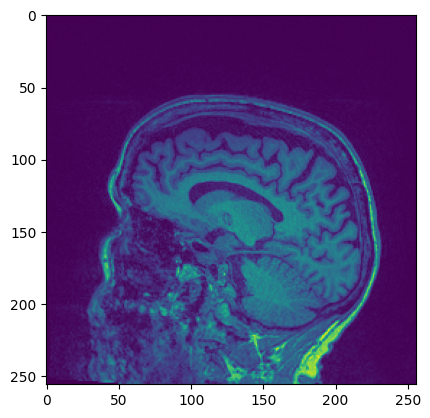

In [11]:
### preview sample image
pixels = dicom.dcmread(data_df['full_path'].iloc[8000]).pixel_array
print('Image shape:', pixels.shape)
plt.imshow(pixels);

In [12]:
### validate shapes of all samples
sample_shapes = {}
for i, full_path in enumerate(data_df['full_path']):
  pixels = dicom.dcmread(full_path).pixel_array
  sample_shape = pixels.shape

  if sample_shape not in sample_shapes:
    sample_shapes[sample_shape] = 1
  else:
    sample_shapes[sample_shape] += 1

  if i % 5000 == 0:
    print(f"Image {i} processed")

sample_shapes

Image 0 processed
Image 5000 processed
Image 10000 processed
Image 15000 processed
Image 20000 processed


{(256, 240): 15648, (256, 256): 4768}

# Model Input

In [13]:
def path_to_pixels(full_path):
  """load image from path, expected to be either (256, 256), or (256, 240), in which case pad to (256, 256)"""
  # load pixels
  ds = dicom.dcmread(full_path).pixel_array
  assert (ds.shape == (256, 256)) or (ds.shape == (256, 240))

  # reshape to (256, 256)
  pad_cols = int((256 - ds.shape[1]) / 2)
  assert (pad_cols == 0) or (pad_cols == 8)
  ds_padded = np.pad(ds, ((0, 0), (pad_cols, pad_cols)), 'constant')
  assert ds_padded.shape == (256, 256)

  return ds_padded

In [14]:
### get X (pixels) and y

X = []
y = []
for label, full_path in zip(data_df['label'], data_df['full_path']):
  X.append(path_to_pixels(full_path))
  y.append(label)

X = np.array(X)
y = np.array(y)

In [15]:
# one hot encode
from keras.utils import to_categorical
y_onehot = to_categorical(y)

In [16]:
# make the new directory for safe keeping
directory = '/content/silvia_cache'
if not os.path.exists(directory):
    os.makedirs(directory)

# Now you can safely save your files
np.save('/content/silvia_cache/X.npy', X)
np.save('/content/silvia_cache/y.npy', y)
np.save('/content/silvia_cache/y_onehot.npy', y_onehot)


In [17]:
X = np.load('/content/silvia_cache/X.npy')
y = np.load('/content/silvia_cache/y.npy')

In [18]:
display(X.shape)
display(y.shape)

(20416, 256, 256)

(20416,)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)
del X
del y
y_train_onehot, y_test_onehot = to_categorical(y_train), to_categorical(y_test)

display(X_train.shape)
display(y_train.shape)
display(y_train_onehot.shape)
display(X_test.shape)
display(y_test.shape)
display(y_test_onehot.shape)

(14291, 256, 256)

(14291,)

(14291, 3)

(6125, 256, 256)

(6125,)

(6125, 3)

## Training/Testing Model_2

eric_cache/model2_v1.model is trained with 1 epoch

eric_cache/model2_v2.model is trained with 5 epochs

In [20]:
import tensorflow as tf


def Conv_2D_Block(x, model_width, kernel, strides):
    # 2D Convolutional Block with BatchNormalization
    x = tf.keras.layers.Conv2D(model_width, kernel, strides=strides, padding="same", kernel_initializer="he_normal")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x


def SE_Block(inputs, num_filters, ratio):
    squeeze = tf.keras.layers.GlobalAveragePooling2D()(inputs)

    excitation = tf.keras.layers.Dense(units=num_filters/ratio)(squeeze)
    excitation = tf.keras.layers.Activation('relu')(excitation)
    excitation = tf.keras.layers.Dense(units=num_filters)(excitation)
    excitation = tf.keras.layers.Activation('sigmoid')(excitation)
    excitation = tf.keras.layers.Reshape([1, 1, num_filters])(excitation)

    scale = inputs * excitation

    return scale


def stem_bottleneck(inputs, num_filters):
    # Construct the Stem Convolution Group
    # inputs : input vector
    # First Convolutional layer, where pooled feature maps will be reduced by 75%
    conv = Conv_2D_Block(inputs, num_filters, (7, 7), (2, 2))
    if conv.shape[1] <= 2:
        pool = tf.keras.layers.MaxPooling2D(pool_size=(1, 1), strides=(2, 2), padding="valid")(conv)
    else:
        pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(conv)

    return pool


def conv_block(inputs, num_filters):
    # Construct Block of Convolutions without Pooling
    # x        : input into the block
    # n_filters: number of filters
    conv = Conv_2D_Block(inputs, num_filters, (3, 3), (2, 2))
    conv = Conv_2D_Block(conv, num_filters, (3, 3), (1, 1))

    return conv


def grouped_convolution_block(inputs, num_filters, kernel_size, strides, cardinality):
    # Adds a grouped convolution block
    group_list = []
    grouped_channels = int(num_filters / cardinality)

    if cardinality == 1:
        # When cardinality is 1, it is just a standard convolution
        x = Conv_2D_Block(inputs, num_filters, (1, 1), strides=(strides, strides))
        x = Conv_2D_Block(x, grouped_channels, (kernel_size, kernel_size), (strides, strides))

        return x

    for c in range(cardinality):
        x = tf.keras.layers.Lambda(lambda z: z[:, :, :, c * grouped_channels:(c + 1) * grouped_channels])(inputs)
        x = Conv_2D_Block(x, num_filters, (1, 1), strides=(strides, strides))
        x = Conv_2D_Block(x, grouped_channels, (kernel_size, kernel_size), strides=(strides, strides))

        group_list.append(x)

    group_merge = tf.keras.layers.concatenate(group_list, axis=-1)
    x = tf.keras.layers.BatchNormalization()(group_merge)
    x = tf.keras.layers.Activation('relu')(x)

    return x


def residual_block_bottleneck(inputs, num_filters, cardinality, ratio):
    # Construct a Residual Block of Convolutions
    # x        : input into the block
    # n_filters: number of filters
    shortcut = Conv_2D_Block(inputs, num_filters * 2, (1, 1), (1, 1))
    #
    x = grouped_convolution_block(inputs, num_filters, 3, 1, cardinality)
    x = SE_Block(x, num_filters, ratio)
    x = Conv_2D_Block(x, num_filters * 2, (1, 1), (1, 1))
    #
    conv = tf.keras.layers.Add()([x, shortcut])
    out = tf.keras.layers.Activation('relu')(conv)

    return out


def residual_group_bottleneck(inputs, num_filters, n_blocks, cardinality, ratio, conv=True):
    # x        : input to the group
    # n_filters: number of filters
    # n_blocks : number of blocks in the group
    # conv     : flag to include the convolution block connector
    out = inputs
    for _ in range(n_blocks):
        out = residual_block_bottleneck(out, num_filters, cardinality, ratio)

    # Double the size of filters and reduce feature maps by 75% (strides=2, 2) to fit the next Residual Group
    if conv:
        out = conv_block(out, num_filters * 2)

    return out


def learner18(inputs, num_filters, cardinality, ratio):
    # Construct the Learner
    x = residual_group_bottleneck(inputs, num_filters, 2, cardinality, ratio)  # First Residual Block Group of 64 filters
    x = residual_group_bottleneck(x, num_filters * 2, 1, cardinality, ratio)  # Second Residual Block Group of 128 filters
    x = residual_group_bottleneck(x, num_filters * 4, 1, cardinality, ratio)  # Third Residual Block Group of 256 filters
    out = residual_group_bottleneck(x, num_filters * 8, 1, cardinality, ratio, False)  # Fourth Residual Block Group of 512 filters

    return out


def learner34(inputs, num_filters, cardinality, ratio):
    # Construct the Learner
    x = residual_group_bottleneck(inputs, num_filters, 3, cardinality, ratio)  # First Residual Block Group of 64 filters
    x = residual_group_bottleneck(x, num_filters * 2, 3, cardinality, ratio)  # Second Residual Block Group of 128 filters
    x = residual_group_bottleneck(x, num_filters * 4, 5, cardinality, ratio)  # Third Residual Block Group of 256 filters
    out = residual_group_bottleneck(x, num_filters * 8, 2, cardinality, ratio, False)  # Fourth Residual Block Group of 512 filters

    return out


def learner50(inputs, num_filters, cardinality, ratio):
    # Construct the Learner
    x = residual_group_bottleneck(inputs, num_filters, 3, cardinality, ratio)  # First Residual Block Group of 64 filters
    x = residual_group_bottleneck(x, num_filters * 2, 3, cardinality, ratio)  # Second Residual Block Group of 128 filters
    x = residual_group_bottleneck(x, num_filters * 4, 5, cardinality, ratio)  # Third Residual Block Group of 256 filters
    out = residual_group_bottleneck(x, num_filters * 8, 2, cardinality, ratio, False)  # Fourth Residual Block Group of 512 filters

    return out


def learner101(inputs, num_filters, cardinality, ratio):
    # Construct the Learner
    x = residual_group_bottleneck(inputs, num_filters, 3, cardinality, ratio)  # First Residual Block Group of 64 filters
    x = residual_group_bottleneck(x, num_filters * 2, 3, cardinality, ratio)  # Second Residual Block Group of 128 filters
    x = residual_group_bottleneck(x, num_filters * 4, 22, cardinality, ratio)  # Third Residual Block Group of 256 filters
    out = residual_group_bottleneck(x, num_filters * 8, 2, cardinality, ratio, False)  # Fourth Residual Block Group of 512 filters

    return out


def learner152(inputs, num_filters, cardinality, ratio):
    # Construct the Learner
    x = residual_group_bottleneck(inputs, num_filters, 3, cardinality, ratio)  # First Residual Block Group of 64 filters
    x = residual_group_bottleneck(x, num_filters * 2, 7, cardinality, ratio)  # Second Residual Block Group of 128 filters
    x = residual_group_bottleneck(x, num_filters * 4, 35, cardinality, ratio)  # Third Residual Block Group of 256 filters
    out = residual_group_bottleneck(x, num_filters * 8, 2, cardinality, ratio, False)  # Fourth Residual Block Group of 512 filters

    return out


def classifier(inputs, class_number):
    # Construct the Classifier Group
    # inputs       : input vector
    # class_number : number of output classes
    out = tf.keras.layers.Dense(class_number, activation='softmax')(inputs)

    return out


def regressor(inputs, feature_number):
    # Construct the Regressor Group
    # inputs       : input vector
    # feature_number : number of output features
    out = tf.keras.layers.Dense(feature_number, activation='linear')(inputs)

    return out


class SEResNeXt:
    def __init__(self, length, width, num_channel, num_filters, cardinality=4, ratio=4, problem_type='Regression',
                 output_nums=1, pooling='avg', dropout_rate=False):
        self.length = length
        self.width = width
        self.num_channel = num_channel
        self.num_filters = num_filters
        self.cardinality = cardinality
        self.ratio = ratio
        self.problem_type = problem_type
        self.output_nums = output_nums
        self.pooling = pooling
        self.dropout_rate = dropout_rate

    def MLP(self, x):
        outputs = []
        if self.pooling == 'avg':
            x = tf.keras.layers.GlobalAveragePooling2D()(x)
        elif self.pooling == 'max':
            x = tf.keras.layers.GlobalMaxPooling2D()(x)
        # Final Dense Outputting Layer for the outputs
        x = tf.keras.layers.Flatten(name='flatten')(x)
        if self.dropout_rate:
            x = tf.keras.layers.Dropout(self.dropout_rate, name='Dropout')(x)
        outputs = tf.keras.layers.Dense(self.output_nums, activation='linear')(x)
        if self.problem_type == 'Classification':
            outputs = tf.keras.layers.Dense(self.output_nums, activation='softmax')(x)

        return outputs

    def SEResNeXt18(self):
        inputs = tf.keras.Input((self.length, self.width, self.num_channel))  # The input tensor
        stem_ = stem_bottleneck(inputs, self.num_filters)  # The Stem Convolution Group
        x = learner18(stem_, self.num_filters, self.cardinality, self.ratio)  # The learner
        outputs = self.MLP(x)
        # Instantiate the Model
        model = tf.keras.Model(inputs, outputs)

        return model

    def SEResNeXt34(self):
        inputs = tf.keras.Input((self.length, self.width, self.num_channel))  # The input tensor
        stem_ = stem_bottleneck(inputs, self.num_filters)  # The Stem Convolution Group
        x = learner34(stem_, self.num_filters, self.cardinality, self.ratio)  # The learner
        outputs = self.MLP(x)
        # Instantiate the Model
        model = tf.keras.Model(inputs, outputs)

        return model

    def SEResNeXt50(self):
        inputs = tf.keras.Input((self.length, self.width, self.num_channel))  # The input tensor
        stem_b = stem_bottleneck(inputs, self.num_filters)  # The Stem Convolution Group
        x = learner50(stem_b, self.num_filters, self.cardinality, self.ratio)  # The learner
        outputs = self.MLP(x)
        # Instantiate the Model
        model = tf.keras.Model(inputs, outputs)

        return model

    def SEResNeXt101(self):
        inputs = tf.keras.Input((self.length, self.width, self.num_channel))  # The input tensor
        stem_b = stem_bottleneck(inputs, self.num_filters)  # The Stem Convolution Group
        x = learner101(stem_b, self.num_filters, self.cardinality, self.ratio)  # The learner
        outputs = self.MLP(x)
        # Instantiate the Model
        model = tf.keras.Model(inputs, outputs)

        return model

    def SEResNeXt152(self):
        inputs = tf.keras.Input((self.length, self.width, self.num_channel))  # The input tensor
        stem_b = stem_bottleneck(inputs, self.num_filters)  # The Stem Convolution Group
        x = learner152(stem_b, self.num_filters, self.cardinality, self.ratio)  # The learner
        outputs = self.MLP(x)
        # Instantiate the Model
        model = tf.keras.Model(inputs, outputs)

        return model

In [21]:
if __name__ == '__main__':
    # Configurations
    length = 256  # Assuming your input images are 256x256
    width = 256
    num_channel = 1  # Grayscale images
    model_width = 64  # Initial number of filters
    cardinality = 8
    reduction_ratio = 4
    output_nums = 3  # Assuming three classes for classification
    problem_type = 'Classification'

    # Instantiate and build model
    model = SEResNeXt(length, width, num_channel, model_width, cardinality=cardinality, ratio=reduction_ratio,
                      problem_type=problem_type, output_nums=output_nums, pooling='avg', dropout_rate=False).SEResNeXt152()

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
                  loss='categorical_crossentropy',  # Use categorical_crossentropy for classification
                  metrics=['accuracy'])  # Typically use 'accuracy' for classification tasks

    # Print model summary
    model.summary()


Streaming output truncated to the last 5000 lines.
                                                                                                  
 conv2d_416 (Conv2D)         (None, 16, 16, 256)          8448      ['lambda_183[0][0]']          
                                                                                                  
 batch_normalization_424 (B  (None, 16, 16, 256)          1024      ['conv2d_402[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_426 (B  (None, 16, 16, 256)          1024      ['conv2d_404[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_428 (B  (None, 16, 16, 256)          

In [22]:
batch_size = 1
no_epochs = 3
no_classes = 3  # for Parkinson, Prodromal, and Control
verbosity = 1
learning_rate = 0.001

In [25]:
X_train.shape

(14291, 256, 256)

In [26]:
# Randomly select 300 indices without replacement
indices = np.random.choice(X_train.shape[0], 300, replace=False)

# Use these indices to select samples
X_train_subset = X_train[indices]
y_train_onehot_subset = y_train_onehot[indices]

# Check the shape to confirm the selection
print(X_train_subset.shape)
print(y_train_onehot_subset.shape)

(300, 256, 256)
(300, 3)


In [ ]:
model.fit(
    X_train_subset,
    y_train_onehot_subset,
    batch_size=batch_size,
    epochs=no_epochs,
    verbose=verbosity,
)

Epoch 1/3


In [ ]:
model.save('/content/silvia_cache/model_resnet50.model')

In [ ]:
model.evaluate(
    X_train,
    y_train_onehot,
    batch_size=batch_size,
    verbose=verbosity
)

14291/14291 [==============================] - 203s 14ms/step - loss: 844.5966 - accuracy: 0.4344


[844.5965576171875, 0.434399276971817]

In [ ]:
model.evaluate(
    X_test,
    y_test_onehot,
    batch_size=batch_size,
    verbose=verbosity
)

6125/6125 [==============================] - 86s 14ms/step - loss: 800.6835 - accuracy: 0.4542


[800.6835327148438, 0.45420408248901367]

## Test Model_1

In [ ]:
model_a = keras.models.load_model('/content/model_1_a.model')

In [ ]:
model_a.evaluate(
    X_test,
    y_test,
    batch_size=batch_size,
    verbose=verbosity
)

6125/6125 [==============================] - 14s 2ms/step - loss: 1.3921


1.3921126127243042

In [ ]:
model_b = keras.models.load_model('/content/model_1_b.model')

In [ ]:
model_b.evaluate(
    X_test,
    y_test,
    batch_size=batch_size,
    verbose=verbosity
)

6125/6125 [==============================] - 14s 2ms/step - loss: 2.2993


2.299290895462036